# Data exploration and setup for data science bowl 2018

Created by FengTing Liao, Feb 2018

The easy way would be steeling other's code lol

1. Need to obtain a list of paths to the data images
2. Need to scan some images and see what's interesting
3. Need to identify technical aspect of the image, i.e. image size?, RGB?, format? Setup a function which load my training data.
4. Need to get the label data efficiently

### Ultimately, the data set will be prepared and passed through a CNN.

A few excellent notebooks from others
* https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277
* https://www.kaggle.com/stkbailey/teaching-notebook-for-total-imaging-newbies
* https://www.kaggle.com/kmader/nuclei-overview-to-submission

### Step0: Look at what the labes look like

In [1]:
import pandas as pd
import numpy as np

## Let keep the random seed consistent for now...
seed = 42
#random.seed = seed
np.random.seed = seed

In [2]:
pathtodata = '/Volumes/GoogleDrive/My Drive/SoftwareDevelopment/data/DataScienceBowl2018'
ylabels = pd.read_csv(pathtodata + '/stage1_train_labels.csv')

In [3]:
print(ylabels.shape)
print(ylabels['EncodedPixels'][0])
print(len(ylabels['EncodedPixels'][0]))
ylabels.head()

(29461, 2)
6908 1 7161 8 7417 8 7672 9 7928 9 8184 9 8440 9 8696 9 8952 9 9209 8 9465 8 9722 7 9978 7 10235 6 10493 4 10752 1
114


,ImageId,EncodedPixels
0,00071198d059ba7f5914a526d124d28e6d010c92466da2...,6908 1 7161 8 7417 8 7672 9 7928 9 8184 9 8440...
1,00071198d059ba7f5914a526d124d28e6d010c92466da2...,36269 7 36523 11 36778 13 37033 15 37288 17 37...
2,00071198d059ba7f5914a526d124d28e6d010c92466da2...,19919 6 20174 8 20429 10 20685 11 20941 12 211...
3,00071198d059ba7f5914a526d124d28e6d010c92466da2...,18671 6 18926 8 19181 9 19436 10 19691 11 1994...
4,00071198d059ba7f5914a526d124d28e6d010c92466da2...,40158 3 40413 5 40669 5 40925 5 41182 3


### Step1: Establish a path library to the data images

Basically steel from the excellent tutorial from here(https://www.kaggle.com/stkbailey/teaching-notebook-for-total-imaging-newbies)

In [4]:
import pathlib
import imageio

#
# == Glob the training data and load a single image path. 
# Getting a list of all the image data path
#
training_paths = pathlib.Path(pathtodata+'/stage1_train').glob('*/images/*.png')
training_sorted = sorted([x for x in training_paths])
test_paths = pathlib.Path(pathtodata+'/stage1_train').glob('*/images/*.png')

In [5]:
print('How manage images in the data = {}'.format(len(training_sorted)))

How manage images in the data = 670


In [6]:
# == Pick an image and look at its shape 
sample_img_path = training_sorted[45]

# == Readin the image data with the imageio library
# == This gives a numpy array of some shape
sample_img = imageio.imread(str(sample_img_path))

In [7]:
## == Let's look at the shape of an image
print('Shape of an image: {}'.format(sample_img.shape))

## == Coerce an image into gray scale colour..
## == This could be helpful in eliminating the colour dependent of the nucleus
from skimage.color import rgb2gray
sample_img_gray = rgb2gray(sample_img)
print('New image shape: {}'.format(sample_img_gray.shape))

Shape of an image: (520, 696, 4)
New image shape: (520, 696)


### Step2: Let's look at a few images.....

Use matplotlib

In [8]:
## Let's import the plotting library
import matplotlib.pyplot as plt
%matplotlib inline

"\nmask_paths = pathlib.Path(pathtodata+'/stage1_train').glob('*/masks/*.png')\ntraining_mask_sorted = sorted([x for x in training_mask_paths])\nfig_mask, m_mask_axs = plt.subplots(i_img, j_img, figsize = (16, 16))\n"

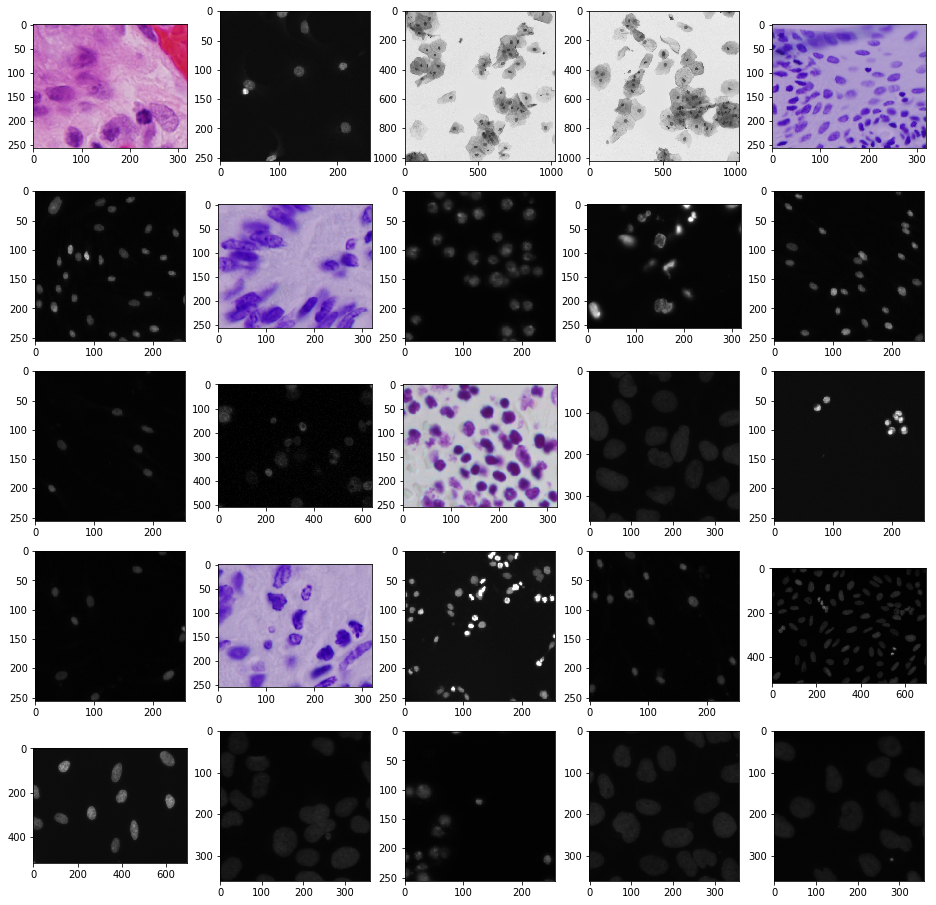

In [9]:
#random_img = imageio(imread(np.random.randint()))


i_img, j_img = 5, 5
fig, m_axs = plt.subplots(i_img, j_img, figsize = (16, 16))
for i in range(i_img):
    for j in range(j_img):
        tmpIMG = imageio.imread(str(training_sorted[np.random.choice(len(training_sorted))]))
        axsimg = m_axs[i][j].imshow(tmpIMG)
        #m_axs[i][j].axis('off')
        #axsimg.title(str(tmpIMG.shape))


"""
mask_paths = pathlib.Path(pathtodata+'/stage1_train').glob('*/masks/*.png')
training_mask_sorted = sorted([x for x in training_mask_paths])
fig_mask, m_mask_axs = plt.subplots(i_img, j_img, figsize = (16, 16))
"""


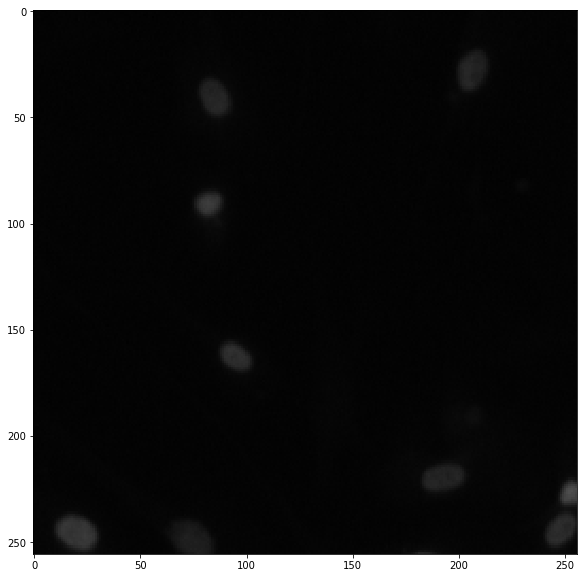

In [10]:
# Closer look of a random single image
fig, m_axs = plt.subplots(1,1, figsize = (10, 10))
img_id = np.random.choice(len(training_sorted))
m_axs.imshow(imageio.imread(str(training_sorted[img_id])))
#plt.show()

Looks like the shape of images are different. 

Solutions?
1. Pad the image to the same shape..
2. Reshape the image? (less ideal probably)

### Step 3: Prepare a function to load training and test data

As title, need to get a function to load things easily

In [11]:
## Taking experience from https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277
import os
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

In [12]:
TRAIN_PATH=pathtodata+'/stage1_train'
TEST_PATH=pathtodata+'/stage1_test'
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 4
def load_data(train_path=TRAIN_PATH, test_path=TEST_PATH
             ,img_width=IMG_WIDTH, img_height=IMG_HEIGHT, img_channels=IMG_CHANNELS
             ,get_all_data=True):
    """
        Input:
            trina_path: path to the training data containing the images and mask
            test_path: path to the testing data containing only the test images
            
        Return:
            x_train: numpy array of the training data for training input
            y_train: numpy array of the ground truth for the training input
            x_test: numpy array of the test data for test input
    """
    
    # Getting images folders within a given folder path
    # This gives an array of the paths
    train_ids = next(os.walk(train_path))[1]
    test_ids = next(os.walk(test_path))[1]
    
    # Initialize the data arrays
    x_train = np.zeros((len(train_ids), img_height, img_width, img_channels), dtype=np.uint8)
    y_train = np.zeros((len(train_ids), img_height, img_width, 1), dtype=np.bool)
    x_test = np.zeros((len(test_ids), img_height, img_width, img_channels), dtype=np.bool)
    
    trainImgShapeList = []
    testImgShapeList = []
    
    ## Loop through all the folders of the train dataset
    for i, id_folder  in enumerate(train_ids):
        ## Putting images into the training array
        imgpath = train_path+'/'+id_folder+'/images/'+id_folder+'.png'
        img = imread(imgpath)
        trainImgShapeList.append(img.shape)
        img = resize(img, (img_height, img_width, img_channels), mode='constant', preserve_range=True)
        x_train[i]=img;
        
        ### Loop through all the mask images in a given data image
        mask = np.zeros((img_height, img_width, 1), dtype=np.bool)
        maskpath=train_path+'/'+id_folder+'/masks'
        mask_ids = next(os.walk(maskpath))[2]
        for mask_file in mask_ids:
            maskimg = imread(maskpath+'/'+mask_file)
            ### Resize the mask image to (img_height, img_width, 1)
            maskimg = resize(maskimg, (img_height, img_width), mode='constant', preserve_range=True)
            maskimg = np.expand_dims(maskimg, axis=-1)
            ### Selecting out the mask in a given single image
            mask = np.maximum(mask, maskimg)
            #print('mask image shape = ', maskimg.shape)
            
        y_train[i] = mask
        if(not get_all_data and i&10==0): break
    ## End of loop
    
    print('Finish setting up the training data')
    
    ## Loop through all the folders of the test dataset
    for i, id_folder  in enumerate(test_ids):
        ## Putting images into the test array
        imgpath = test_path+'/'+id_folder+'/images/'+id_folder+'.png'
        img = imread(imgpath)
        testImgShapeList.append(img.shape)
        img = resize(img, (img_height, img_width, img_channels), mode='constant', preserve_range=True)
        x_test[i]=img;
        if(not get_all_data and i%10==0): break
    ## End of loop
    cache = {'train_imgs_shapes': trainImgShapeList,
             'test_imgs_shapes': testImgShapeList,
             'train_ids':train_ids, 
             'test_ids': test_ids, 
             'train_path': train_path, 
             'test_path': test_path, 
             'img_height': img_height, 
             'img_width': img_width, 
             'img_channels': img_channels, 
             'get_all_data': get_all_data}
    
    return x_train, y_train, x_test, cache

##### Let's grab a few images an look at them

In [13]:
%%time
## Last look at a image and its mask
x_train, y_train, _, cache = load_data(img_height=256, img_width=256, img_channels=4, get_all_data=False)
print(x_train.shape, y_train.shape)
print('Train img shape = {}'.format(cache['train_imgs_shapes'][0]))

Finish setting up the training data
((670, 256, 256, 4), (670, 256, 256, 1))
Train img shape = (256, 256, 4)
CPU times: user 263 ms, sys: 52.1 ms, total: 315 ms
Wall time: 541 ms


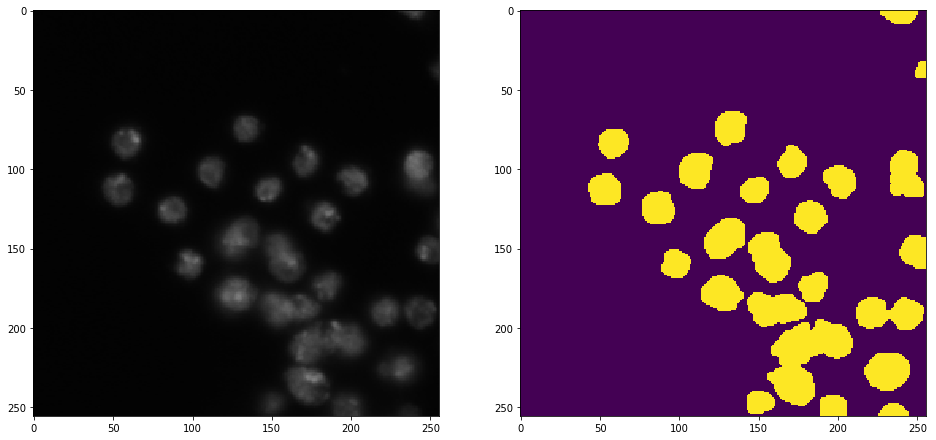

In [16]:
fig, m_axs = plt.subplots(1,2, figsize = (16, 32))
#img_id = np.random.choice(x_train.shape[0])
img_id = 0
m_axs[0].imshow(x_train[img_id,:,:,:])
m_axs[1].imshow(y_train[img_id,:,:,0])

In [17]:
%%time
x_train, y_train, y_test, cache = load_data(get_all_data=True)
print(x_train.shape, y_train.shape)

Finish setting up the training data
((670, 256, 256, 4), (670, 256, 256, 1))
CPU times: user 3min 5s, sys: 24.1 s, total: 3min 29s
Wall time: 4min 33s


#### Let's grab the full dataset and look a few random images with their masks

CPU times: user 8 µs, sys: 4 µs, total: 12 µs
Wall time: 16 µs


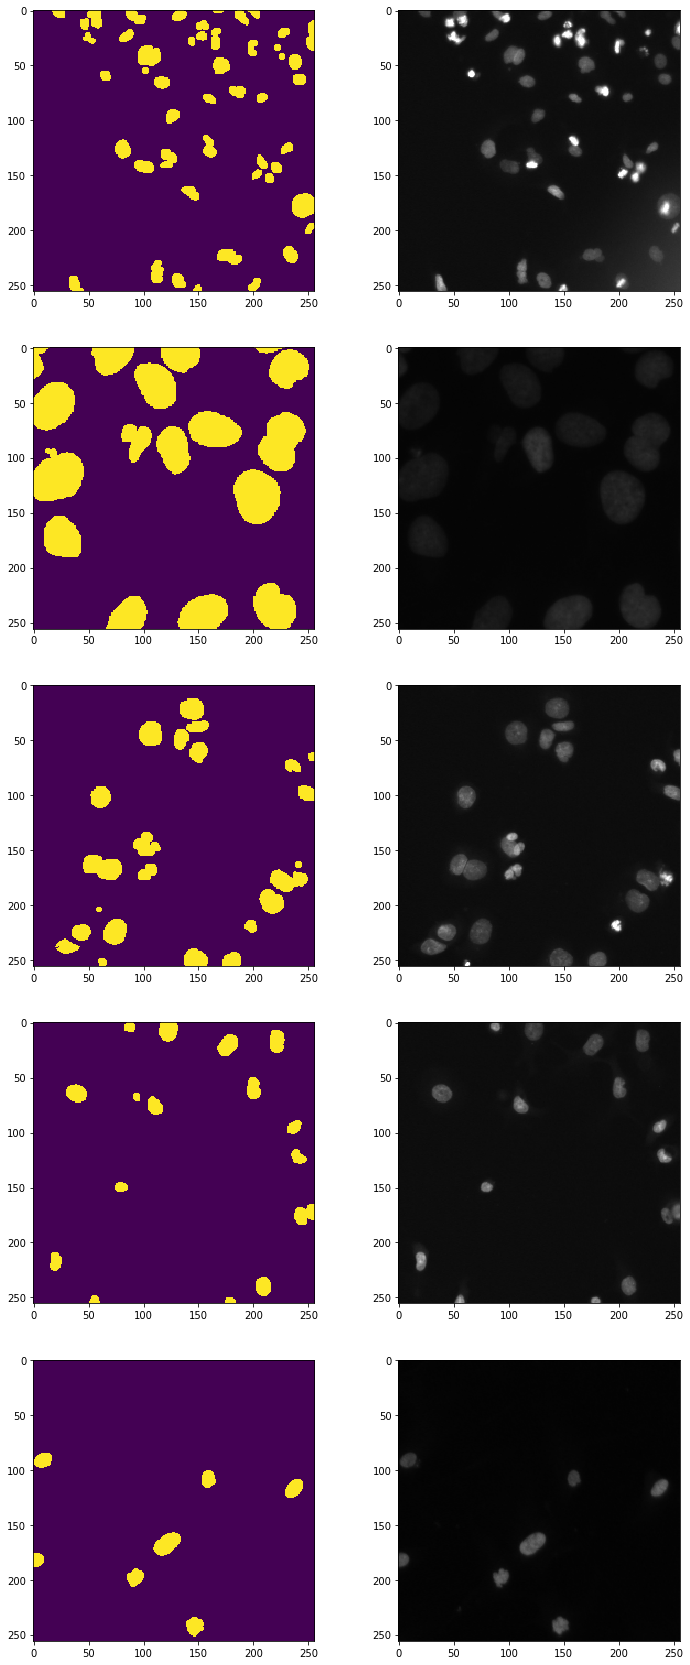

In [18]:
%time
i_img, j_img = 5, 2
fig, m_axs = plt.subplots(i_img, j_img, figsize = (j_img*6, i_img*6))
for i in range(i_img):
    img_idx = np.random.choice(670)
    for j in range(j_img):
        #tmpIMG = imageio.imread(str(training_sorted[np.random.choice(len(training_sorted))]))
        if((j+1)%2==0):
            m_axs[i][j].imshow(x_train[img_idx,:,:,:])
        else:
            m_axs[i][j].imshow(y_train[img_idx,:,:,0])

### Step 4: See how to convert a segmented output to rle encoding

Basically using code from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python

* The recovery of encoding for a give image isn't correct. Since images has been resize, maybe I should recover them before doing rle_encoding...
* Resizing doesn't seem to affect the encoding. Need to understand how to set the labels correctly. RLE doesn't seem to be a good function.

In [66]:
from skimage.morphology import label
def rle_encoding(x):
    """
        input: 
            x: numpy array of shape (height, width) 
        return:
            run_lengths: an array of potential rel regions
    """
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

## Another RLE method stealed from https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/submission.py
def run_length_enc(label):
    from itertools import chain
    x = label.transpose().flatten()
    y = np.where(x > 0)[0]
    if len(y) < 10:  # consider as empty
        return ''
    z = np.where(np.diff(y) > 1)[0]
    start = np.insert(y[z+1], 0, y[0])
    end = np.append(y[z], y[-1])
    length = end - start
    res = [[s+1, l+1] for s, l in zip(list(start), list(length))]
    res = list(chain.from_iterable(res))
    return ' '.join([str(r) for r in res])

#### Encapsulating the rle transformation 
Input: y_predict for your training, cache containing train_ida, train_imgs_shapes
Output: a pandas data frame with ImageId and EncodedPixels

In [67]:
def ConvertPrediction2RLE(prediction, cache, method=1):
    """
        input: 
            prediction: a numpy array of predicted mask images
            cache: the output from the loaddata function
            
        output:
            
    """
    new_test_ids = []
    rles = []
    train_ids = cache['train_ids']
    for n, id_folder in enumerate(train_ids):
        shape = cache['train_imgs_shapes'][n]
        img = resize(y_train[n], (shape[0], shape[1], 1), mode='constant', preserve_range=True)
        #img = y_train[n]
        #if n>10: break   
        #print(y_train[n].shape, shape, img.shape)
        if method == 1:
            rle = list(prob_to_rles(img, cutoff=0.8))
            rles.extend(rle)
            new_test_ids.extend([id_folder] * len(rle))
        elif method == 2:
            rles.append(run_length_enc(img))
            new_test_ids.append(str(id_folder))
        else:
            print('No encoding result returned.')
            return []
        
    pred_rle = pd.DataFrame()
    if method == 1:
        pred_rle['ImageId'] = new_test_ids
        pred_rle['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
    elif method == 2:
        pred_rle['ImageId'] = new_test_ids
        pred_rle['EncodedPixels'] = rles
    return pred_rle

In [71]:
%%time
sub = ConvertPrediction2RLE(y_train, cache, method=1)

CPU times: user 30.2 s, sys: 1.06 s, total: 31.2 s
Wall time: 32.2 s


In [72]:
pred_table = sub.sort_values('ImageId').reset_index(drop=True)
true_table = ylabels.sort_values('ImageId').reset_index(drop=True)

In [75]:
img_id = 30
print(pred_table['ImageId'][img_id],true_table['ImageId'][img_id])
print(pred_table['ImageId'][img_id]==true_table['ImageId'][img_id])

print('RLE in pred_table = {}\n'.format(pred_table['EncodedPixels'][img_id]))
print('RLE in true_table = {}\n'.format(true_table['EncodedPixels'][img_id]))

print(pred_table['EncodedPixels'][1]==true_table['EncodedPixels'][img_id])

('003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1', '003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1')
True
RLE in pred_table = 6145 5 6401 6 6657 6 6913 7 7169 7 7425 7 7681 7 7937 7 8193 6 8449 6 8705 5 8961 4 9217 3 9473 2

RLE in true_table = 3755 5 4010 8 4264 10 4520 11 4775 13 5031 13 5287 13 5543 13 5799 13 6055 13 6311 13 6567 13 6824 12 7081 10 7338 9 7595 6

False


In [62]:
type(true_table['ImageId'][img_id])

str